## Importing Libraries

In [6]:
# Uncomment if running on Google Colab
#!pip install mne gdown

import mne
import scipy.io
import numpy as np
import pathlib
import gdown
import zipfile

## Downloading the zipped data file from Google Drive

In [7]:
cwd = pathlib.Path.cwd()

# Download zip file, if data folder doesn't exist
if not ((cwd/'data.zip').exists() or ((cwd/'data').exists and (cwd/'data').is_dir())):
    url = 'https://drive.google.com/file/d/1y5r8yVxDHqvHck1hsX6TIjnXRpOTP4RE/view?usp=sharing'
    output = 'data.zip'
    gdown.download(url, output, fuzzy=True)


# Extract zip file to the current working directory
if not ((cwd/'data').exists and (cwd/'data').is_dir()):
    with zipfile.ZipFile(cwd/'data.zip', 'r') as zip_ref:
        zip_ref.extractall(cwd)

    # Delete zip file
    (cwd/'data.zip').unlink()

Downloading...
From (original): https://drive.google.com/uc?id=1y5r8yVxDHqvHck1hsX6TIjnXRpOTP4RE
From (redirected): https://drive.google.com/uc?id=1y5r8yVxDHqvHck1hsX6TIjnXRpOTP4RE&confirm=t&uuid=1ded4ca2-9deb-439b-ad5a-feff66ac472d
To: /Users/aaronnezzer/Documents/GitHub/BCI_Project/data.zip
100%|██████████| 414M/414M [00:39<00:00, 10.3MB/s] 


## Importing data

In [8]:
# Get an array of file paths of each subject
directory = pathlib.Path('data')
files = directory.glob('*.mat')
file_paths = sorted([file for file in files if file.is_file()])

## Processing Matlab data to Python data object

In [9]:
def process_mat_file(file_path):
    mat = scipy.io.loadmat(file_path)

    chann = np.array([mat['chann'][0][i][0] for i in range(len(mat['chann'][0]))])
    X = mat['X']
    I = mat['I']
    Y = mat['Y']

    id_lab = np.array([mat['id_lab'][0][i][0] for i in range(len(mat['id_lab'][0]))])

    return {'X': X, 'Y': Y, 'id_lab': id_lab, 'chann': chann, 'I': I}

# Example to obtain processed data from a file
# data = process_mat_file('data/S00.mat')
data.keys()

NameError: name 'data' is not defined

## Process data for ERP analysis

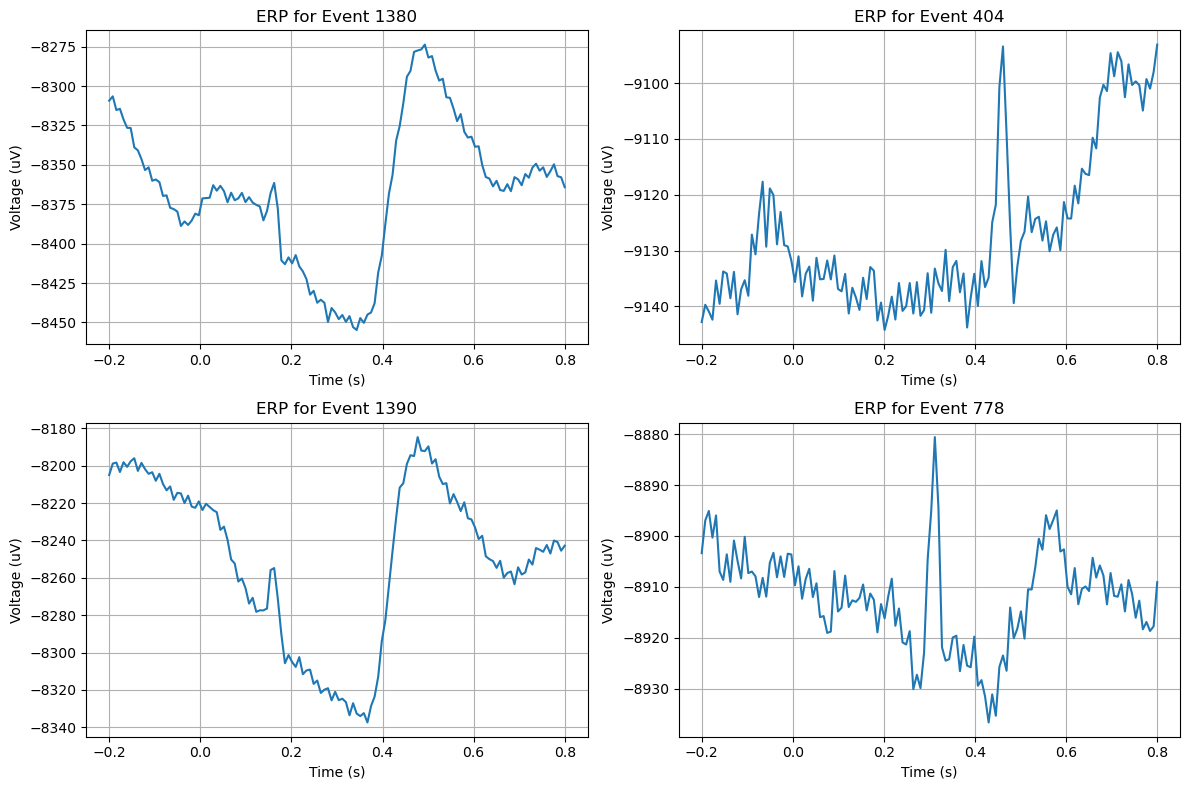

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# Load data from the file S00.mat
mat_data = scipy.io.loadmat('data/S00.mat')

# Extract the first row of X, Y, and I
X_first_row = mat_data['X']
Y_first_row = mat_data['Y'][0]
I_first_row = mat_data['I'][0]

# Define the event codes (Y values) for ERPs
event_codes = [2, 3, 5]

# Set values in Y outside the event codes to 0
Y_events = np.where(np.isin(Y_first_row, event_codes), Y_first_row, 0)

# Find the indices where Y equals the event codes
event_indices = np.where(Y_events > 0)[0]

# Define the time window around each event (in seconds)
time_window_before = 0.2  # 200 milliseconds before event
time_window_after = 0.8   # 800 milliseconds after event

# Extract the EEG readings (X) for each event within the time window for all channels
erps = []
for event_index in event_indices:
    # Calculate the time range around the event
    event_time = I_first_row[event_index]
    window_start = event_time - time_window_before
    window_end = event_time + time_window_after
    
    # Find the indices within the time window
    window_indices = np.where((I_first_row >= window_start) & (I_first_row <= window_end))[0]
    
    # Extract EEG readings for this event for all channels
    if X_first_row.ndim == 1:
        event_eeg = X_first_row[window_indices]
    else:
        event_eeg = X_first_row[:, window_indices]
    
    # Append the event EEG readings to the list of ERPs
    erps.append(event_eeg)

# Convert the list of ERPs to a numpy array for further analysis
erps = np.array(erps)

# Randomly select 4 indices for plotting
num_plots = 4
random_indices = np.random.choice(len(erps), num_plots, replace=False)

# Calculate the time points for the ERP waveform
time_points = np.linspace(-time_window_before, time_window_after, erps.shape[2])

# Plot the average ERP waveform across all channels for the selected indices
plt.figure(figsize=(12, 8))
for i, index in enumerate(random_indices):
    plt.subplot(2, 2, i+1)
    plt.plot(time_points, erps[index].mean(axis=0))
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (uV)')
    plt.title(f'ERP for Event {index}')
    plt.grid(True)

plt.tight_layout()
plt.show()
